# Experiment 1 - Minimum Balancing with 64x64 Resizing

This experiment consists on the pre-processing data pipeline established below:

- Data Balancing with Reduction + Oversampling, resulting in 2,100 training images as final dataset.
- Image Resizing to 64x64 in order to improve performance.
- Pixel Values Normalisation to range 0 to 1.

No further data augmentation was implemented during this experiment

## Initial Setup

This initial setup is used to allow direct import of classes from other Notebooks available on Google Colab.

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project')

## Libraries Import

In [4]:
from google.colab import drive
import pandas as pd
import numpy as np
import keras
from keras import layers, models
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB4, EfficientNetB7, EfficientNetV2M, ResNet50V2, ResNet152V2, InceptionV3, DenseNet121, DenseNet201
import tensorflow as tf
from isic2018_task3_data_preprocessing import DataBalancer, DataPreparer, ModelSpecificProcessor
from isic2018_task3_models import BaseModel
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Instances of the class

In [5]:
db = DataBalancer()
dp = DataPreparer()
msp = ModelSpecificProcessor()

## Train Data Pre-Processing

### Capture and prepare labels data

In this step, the csv file containing diagnosis of lesion type is captured into a dataframe and transformed to provide labels in a single lesion type feature, encode categorical labels, and store image full path based on Google Drive folder structure.

In [6]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/train/ISIC2018_Task3_Training_GroundTruth.csv')
df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
df = dp.labelPathMapper(df, 'train')
df.head()

,image,lesion_type,label_encoded,img_path
0,ISIC_0024306,NV,0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
1,ISIC_0024307,NV,0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
2,ISIC_0024308,NV,0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
3,ISIC_0024309,NV,0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
4,ISIC_0024310,MEL,1,/content/drive/MyDrive/Colab Notebooks/skin-ca...


In [8]:
# Check for any issues with img_path
missing_files = [f for f in df['img_path'].values if not os.path.exists(f)]
print(f"Missing files: {len(missing_files)}")
if missing_files:
    print("Example missing path:", missing_files[0])

Missing files: 0


### Data Balancing

For this experiment, the data balance consists of capturing n random samples of each category where n = the record count of the smallest lesion type in the dataset. Based on ISIC 2018 Train Dataset, as observed in file ISIC2018_Task3_Data_Analysis, this corresponds to lesion DF with 115 records.<br><br>
There are 7 categories, which when sampled to 115 per categories provides 805 records. This is insufficient data for training purposes, therefore oversampling is performed to achieve 300 images per categories, providing 2,100 records for training.

In [9]:
df, ds_train = db.minBalancing(df)

<Axes: xlabel='label_encoded', ylabel='count'>

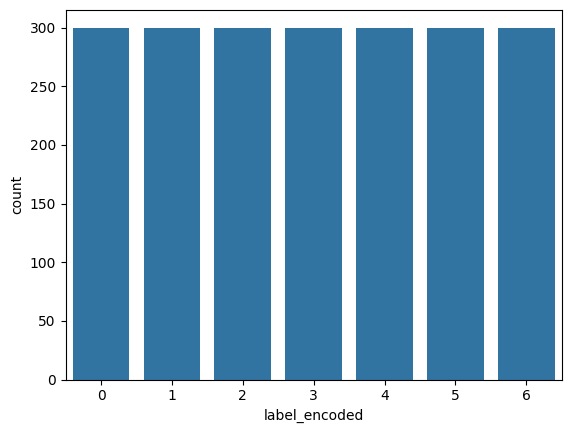

In [10]:
# Check df balance after balancing step
sns.countplot(x='label_encoded', data=df)

### Image Resizing and Normalisation

In [11]:
HEIGHT = 64
WIDTH = 64

def resize_wrapper(path, label):
    return dp.imageResizer(path, label, HEIGHT, WIDTH)

ds_train = ds_train.map(resize_wrapper)

In [12]:
ds_train = ds_train.map(dp.pixelNormalizer)

In [13]:
# Shuffle dataset to provide higher diversity per batch
ds_train = ds_train.shuffle(buffer_size=len(df))

In [14]:
BATCH_SIZE = 32

# Update shape to match model Sequential.call() shape
ds_train = ds_train.batch(BATCH_SIZE)

In [15]:
# Check ds shape and sample batch
for image, label in ds_train.take(1):
    print(image.shape, label.numpy())

(32, 64, 64, 3) [1 3 2 0 3 2 0 0 5 3 1 5 3 0 2 2 0 2 4 5 0 6 0 6 4 1 3 2 6 6 6 5]


## Validation and Test Data Pre-Processing

In [16]:
# Capture Ground Truth and transform dataframe for label use

df_validate = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/validate/ISIC2018_Task3_Validation_GroundTruth.csv')
df_validate = dp.labelPathMapper(df_validate, 'validate')

df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/test/ISIC2018_Task3_Test_GroundTruth.csv')
df_test = dp.labelPathMapper(df_test, 'test')

In [17]:
# Build image tensorflow dataset

ds_validate = db.buildDS(df_validate)
ds_test = db.buildDS(df_test)

In [18]:
# Image resizing

ds_validate = ds_validate.map(resize_wrapper)
ds_test = ds_test.map(resize_wrapper)

In [19]:
# Pixel values normalisation

ds_validate = ds_validate.map(dp.pixelNormalizer)
ds_test = ds_test.map(dp.pixelNormalizer)

In [20]:
# Update shape to match model Sequential.call() shape

ds_validate = ds_validate.batch(BATCH_SIZE)
ds_test = ds_test.batch(BATCH_SIZE)

## Model Building, Training and Validating

In [21]:
NUM_CLASSES = len(df.lesion_type.unique())
CHANNELS = 3
EPOCHS = 8

In [22]:
# Instance of Models class
bm = BaseModel(NUM_CLASSES, HEIGHT, WIDTH, CHANNELS)

In [23]:
# Function to support epoch plotting

def plot_hist(hist, modelName):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title(f"{modelName} model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [24]:
# Function to support confusion matrix plotting
def conf_matrix(ds, model):
  y_true = []
  y_pred = []

  for images, labels in ds:
      preds = model.predict(images)
      y_true.extend(labels.numpy())
      y_pred.extend(np.argmax(preds, axis=1))
  cm = confusion_matrix(y_true, y_pred)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm)

  return disp

In [25]:
# Build Base Models

# Custom CNN Model
custom_CNN = bm.customCNN()
# EfficientNet Models
base_modelENB0 = bm.modelENB0()
base_modelENB4 = bm.modelENB4()
base_modelENB7 = bm.modelENB7()
base_modelENV2M = bm.modelENV2M()
# ResNet Models
base_modelRN50V2 = bm.modelRN50V2()
base_modelRN152V2 = bm.modelRN152V2()
# DenseNet Models
base_modelDN121 = bm.modelDN121()
base_modelDN201 = bm.modelDN201()

# Build custom Fully Connected Layer
custom_final_layer = bm.finalLayer()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
214201816/214201816 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Custom CNN

In [25]:
modelCNN = models.Sequential([
    layers.Input(shape=(HEIGHT,WIDTH,CHANNELS)),
    custom_CNN,
])

modelCNN.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
modelCNN.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 7)              │       692,807 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 692,807 (2.64 MB)

 Trainable params: 692,359 (2.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [26]:
start_time = time.time()
histCNN = modelCNN.fit(ds_train, epochs=EPOCHS, validation_data=ds_validate)
end_time = time.time()
duration = end_time - start_time
print(f"Model Custom CNN Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

Epoch 1/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 46s 393ms/step - accuracy: 0.2971 - loss: 2.2175 - val_accuracy: 0.1088 - val_loss: 3.1212
Epoch 2/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 352ms/step - accuracy: 0.4979 - loss: 1.3388 - val_accuracy: 0.0104 - val_loss: 4.3787
Epoch 3/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 37s 326ms/step - accuracy: 0.6013 - loss: 1.1076 - val_accuracy: 0.0052 - val_loss: 6.7834
Epoch 4/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 329ms/step - accuracy: 0.6699 - loss: 0.9111 - val_accuracy: 0.0052 - val_loss: 8.6186
Epoch 5/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 322ms/step - accuracy: 0.7248 - loss: 0.7329 - val_accuracy: 0.0104 - val_loss: 8.9487
Epoch 6/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 39s 324ms/step - accuracy: 0.7888 - loss: 0.6053 - val_accuracy: 0.0881 - val_loss: 6.6709
Epoch 7/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 360ms/step - accuracy: 0.8161 - loss: 0.5155 - val_accuracy: 0.3057 - val_loss: 4.0609
Epoch 8/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 345ms/step - accuracy: 0.8571 - loss: 0.4041 - val_accuracy: 0.

In [27]:
loss, accuracy = modelCNN.evaluate(ds_validate)
print(f"Overall accuracy on validation set: {accuracy * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step - accuracy: 0.2243 - loss: 5.3112
Overall accuracy on validation set: 24.87%


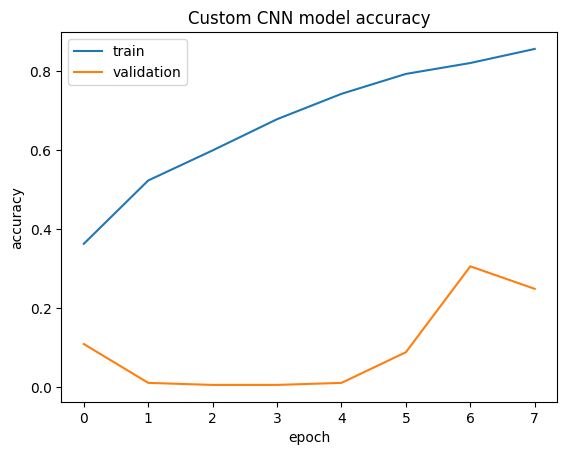

In [28]:
plot_hist(histCNN, "Custom CNN")

In [29]:
predsCNN = modelCNN.predict(ds_validate.take(1))
print(predsCNN.argmax(axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
[5 0 5 6 6 4 6 5 6 6 5 5 4 0 0 0 5 0 5 5 6 0 5 5 5 5 5 6 6 5 6 5]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


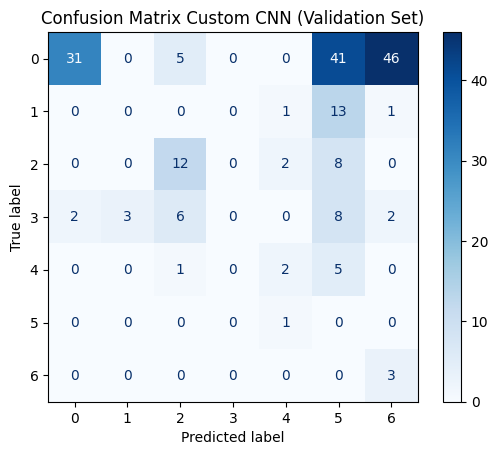

In [30]:
disp = conf_matrix(ds_validate, modelCNN)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix Custom CNN (Validation Set)')
plt.show()

### EfficientNet Models

EfficientNet is a family of Convolutional Neural Networks (CNNs) that scales up models using compound coefficient, which uniformally scales each dimension with fixed coefficients, simultaneously increasing width, depth, and resolution.

In [31]:
ds_train_EN = ds_train.map(msp.efficientNetPrep)
ds_validate_EN = ds_validate.map(msp.efficientNetPrep)
ds_test_EN = ds_test.map(msp.efficientNetPrep)

#### EfficientNet-B0

In [32]:
modelENB0 = models.Sequential([
    layers.Input(shape=(HEIGHT,WIDTH,CHANNELS)),
    base_modelENB0,
    layers.Flatten(),
    custom_final_layer,
])

modelENB0.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
modelENB0.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 2, 2, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 5120)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 7)              │       664,199 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,713,770 (17.98 MB)

 Trainable params: 4,671,747 (17.82 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [33]:
start_time = time.time()
histENB0 = modelENB0.fit(ds_train_EN, epochs=EPOCHS, validation_data=ds_validate_EN)
end_time = time.time()
duration = end_time - start_time
print(f"Model EfficientNet-B0 Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

Epoch 1/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 149s 954ms/step - accuracy: 0.3410 - loss: 1.7670 - val_accuracy: 0.1140 - val_loss: 1.6041
Epoch 2/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 75s 877ms/step - accuracy: 0.5967 - loss: 1.1483 - val_accuracy: 0.0363 - val_loss: 2.7907
Epoch 3/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 72s 849ms/step - accuracy: 0.7063 - loss: 0.8924 - val_accuracy: 0.6373 - val_loss: 1.3371
Epoch 4/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 72s 852ms/step - accuracy: 0.7640 - loss: 0.7184 - val_accuracy: 0.6321 - val_loss: 1.5799
Epoch 5/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 81s 828ms/step - accuracy: 0.8399 - loss: 0.5312 - val_accuracy: 0.3782 - val_loss: 1.8350
Epoch 6/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 82s 803ms/step - accuracy: 0.8722 - loss: 0.4017 - val_accuracy: 0.3472 - val_loss: 1.7171
Epoch 7/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 83s 825ms/step - accuracy: 0.8965 - loss: 0.3497 - val_accuracy: 0.1762 - val_loss: 1.9749
Epoch 8/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 82s 849ms/step - accuracy: 0.8667 - loss: 0.4463 - val_accuracy: 0

In [34]:
loss, accuracy = modelENB0.evaluate(ds_validate_EN)
print(f"Overall accuracy on validation set: {accuracy * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - accuracy: 0.0442 - loss: 2.1162
Overall accuracy on validation set: 7.25%


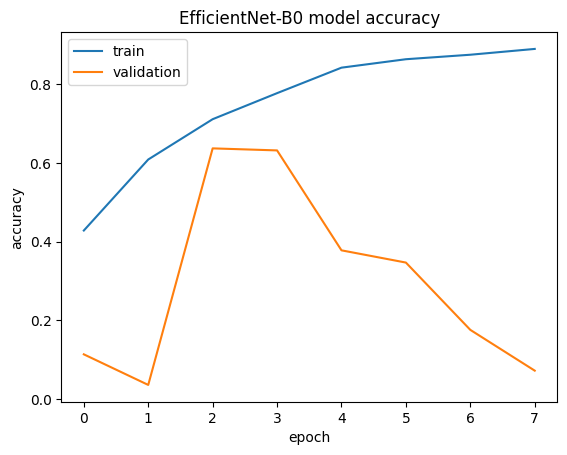

In [35]:
plot_hist(histENB0, "EfficientNet-B0")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


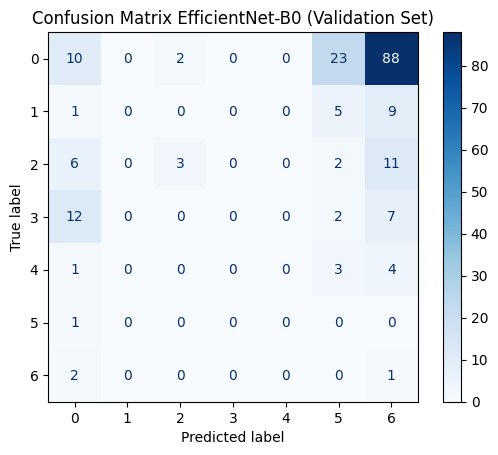

In [36]:
disp = conf_matrix(ds_validate_EN, modelENB0)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix EfficientNet-B0 (Validation Set)')
plt.show()

#### EfficientNet-B4

In [40]:
modelENB4 = models.Sequential([
    base_modelENB4,
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(NUM_CLASSES, activation="softmax"),
])

modelENB4.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
modelENB4.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)     │ (None, 2, 2, 1792)     │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 7168)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       917,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,600,166 (70.95 MB)

 Trainable params: 18,474,959 (70.48 MB)

 Non-trainable params: 125,207 (489.09 KB)

In [41]:
start_time = time.time()
histENB4 = modelENB4.fit(ds_train_EN, epochs=EPOCHS, validation_data=ds_validate_EN)
end_time = time.time()
duration = end_time - start_time
print(f"Model EfficientNet-B4 Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

Epoch 1/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 329s 3s/step - accuracy: 0.3125 - loss: 1.8020 - val_accuracy: 0.1088 - val_loss: 3.6076
Epoch 2/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 238s 2s/step - accuracy: 0.5559 - loss: 1.2578 - val_accuracy: 0.0881 - val_loss: 1.6540
Epoch 3/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 222s 3s/step - accuracy: 0.6826 - loss: 0.9820 - val_accuracy: 0.6373 - val_loss: 1.5206
Epoch 4/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 209s 3s/step - accuracy: 0.7750 - loss: 0.7168 - val_accuracy: 0.1140 - val_loss: 2.0854
Epoch 5/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 243s 3s/step - accuracy: 0.8282 - loss: 0.5979 - val_accuracy: 0.6373 - val_loss: 1.4301
Epoch 6/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 184s 3s/step - accuracy: 0.8729 - loss: 0.4577 - val_accuracy: 0.6373 - val_loss: 1.8373
Epoch 7/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.9004 - loss: 0.4177 - val_accuracy: 0.6373 - val_loss: 1.3295
Epoch 8/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - accuracy: 0.8759 - loss: 0.4102 - val_accuracy: 0.6373 - val_loss:

In [42]:
loss, accuracy = modelENB4.evaluate(ds_validate_EN)
print(f"Overall accuracy on validation set: {accuracy * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 426ms/step - accuracy: 0.6219 - loss: 2.5671
Overall accuracy on validation set: 63.73%


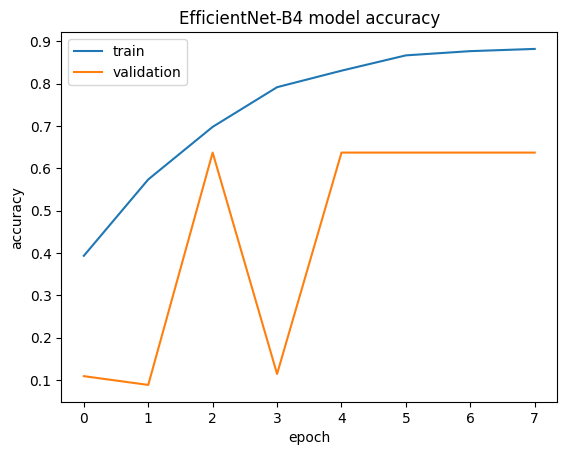

In [43]:
plot_hist(histENB4, "EfficientNet-B4")

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


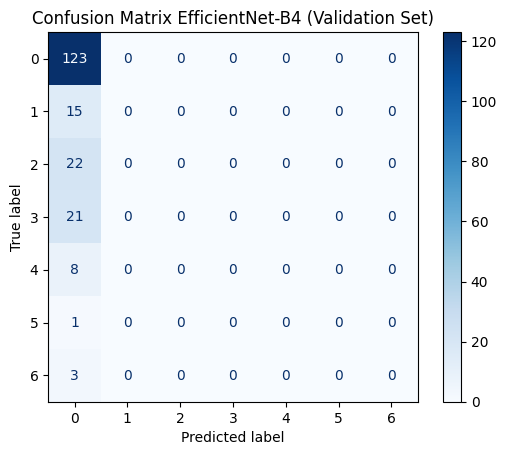

In [44]:
disp = conf_matrix(ds_validate_EN, modelENB4)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix EfficientNet-B4 (Validation Set)')
plt.show()

#### EfficientNet-B7

In [45]:
modelENB7 = models.Sequential([
    base_modelENB7,
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(NUM_CLASSES, activation="softmax"),
])

modelENB7.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
modelENB7.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ (None, 2, 2, 2560)     │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 10240)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │     1,310,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,417,246 (249.55 MB)

 Trainable params: 65,106,519 (248.36 MB)

 Non-trainable params: 310,727 (1.19 MB)

In [46]:
start_time = time.time()
histENB7 = modelENB7.fit(ds_train_EN, epochs=EPOCHS, validation_data=ds_validate_EN)
end_time = time.time()
duration = end_time - start_time
print(f"Model EfficientNet-B7 Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

Epoch 1/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 1019s 12s/step - accuracy: 0.3036 - loss: 1.8724 - val_accuracy: 0.1140 - val_loss: 2.7257
Epoch 2/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 760s 11s/step - accuracy: 0.4897 - loss: 1.3941 - val_accuracy: 0.0777 - val_loss: 2.7387
Epoch 3/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 764s 11s/step - accuracy: 0.6147 - loss: 1.1493 - val_accuracy: 0.0777 - val_loss: 3.3675
Epoch 4/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 705s 10s/step - accuracy: 0.6396 - loss: 1.0785 - val_accuracy: 0.6373 - val_loss: 349.3351
Epoch 5/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 770s 11s/step - accuracy: 0.6831 - loss: 0.9715 - val_accuracy: 0.6373 - val_loss: 24.1546
Epoch 6/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 808s 11s/step - accuracy: 0.7644 - loss: 0.8000 - val_accuracy: 0.6373 - val_loss: 1.3794
Epoch 7/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 766s 11s/step - accuracy: 0.8276 - loss: 0.5894 - val_accuracy: 0.6114 - val_loss: 1.6223
Epoch 8/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 760s 11s/step - accuracy: 0.8506 - loss: 0.5232 - val_accuracy: 0.0207

In [47]:
loss, accuracy = modelENB7.evaluate(ds_validate_EN)
print(f"Overall accuracy on validation set: {accuracy * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.0111 - loss: 5.6927
Overall accuracy on validation set: 2.07%


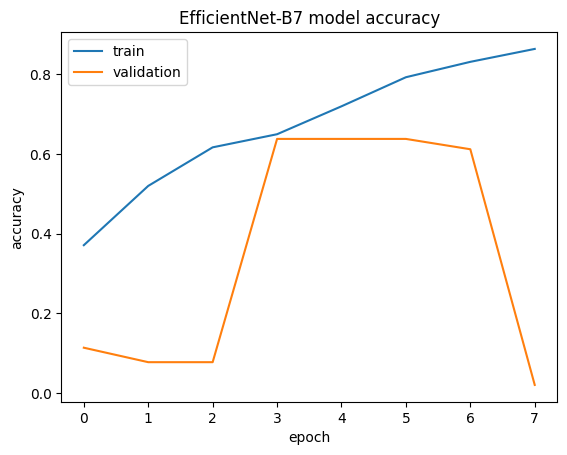

In [48]:
plot_hist(histENB7, "EfficientNet-B7")

1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


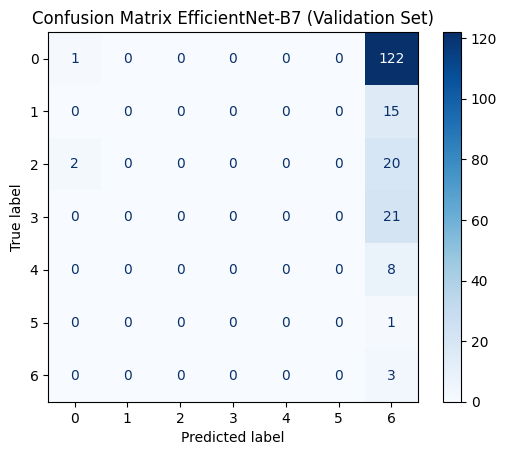

In [49]:
disp = conf_matrix(ds_validate_EN, modelENB7)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix EfficientNet-B7 (Validation Set)')
plt.show()

#### EfficientNetV2-M

In [50]:
modelENV2M = models.Sequential([
    base_modelENV2M,
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(NUM_CLASSES, activation="softmax"),
])

modelENV2M.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
modelENV2M.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-m (Functional)   │ (None, 2, 2, 1280)     │    53,150,388 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 5120)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       655,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,814,587 (205.29 MB)

 Trainable params: 53,522,555 (204.17 MB)

 Non-trainable params: 292,032 (1.11 MB)

In [51]:
start_time = time.time()
histENV2M = modelENV2M.fit(ds_train_EN, epochs=EPOCHS, validation_data=ds_validate_EN)
end_time = time.time()
duration = end_time - start_time
print(f"Model EfficientNetV2-M Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

Epoch 1/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 872s 9s/step - accuracy: 0.2533 - loss: 1.9794 - val_accuracy: 0.0104 - val_loss: 2.5879
Epoch 2/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 532s 8s/step - accuracy: 0.3874 - loss: 1.5646 - val_accuracy: 0.0155 - val_loss: 3.0332
Epoch 3/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 488s 7s/step - accuracy: 0.4304 - loss: 1.4588 - val_accuracy: 0.0155 - val_loss: 4.8601
Epoch 4/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 497s 7s/step - accuracy: 0.5339 - loss: 1.1922 - val_accuracy: 0.0363 - val_loss: 3.4713
Epoch 5/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 501s 7s/step - accuracy: 0.6230 - loss: 1.0379 - val_accuracy: 0.0933 - val_loss: 4.1809
Epoch 6/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 493s 7s/step - accuracy: 0.7259 - loss: 0.8300 - val_accuracy: 0.5285 - val_loss: 1.6863
Epoch 7/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 601s 9s/step - accuracy: 0.7304 - loss: 0.8289 - val_accuracy: 0.4611 - val_loss: 1.6090
Epoch 8/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 584s 8s/step - accuracy: 0.8308 - loss: 0.5399 - val_accuracy: 0.5181 - val_loss:

In [52]:
loss, accuracy = modelENV2M.evaluate(ds_validate_EN)
print(f"Overall accuracy on validation set: {accuracy * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 836ms/step - accuracy: 0.4881 - loss: 2.0354
Overall accuracy on validation set: 51.81%


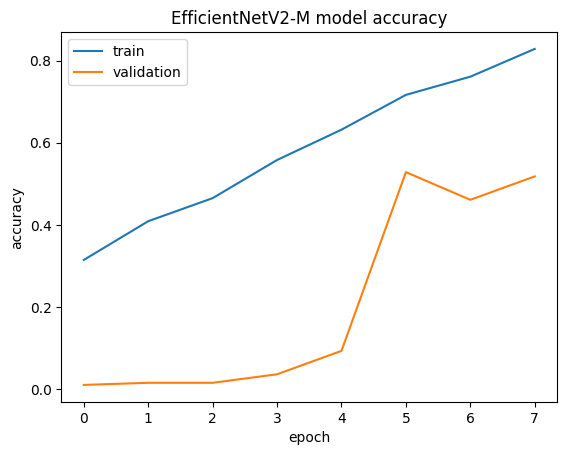

In [53]:
plot_hist(histENV2M, "EfficientNetV2-M")

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


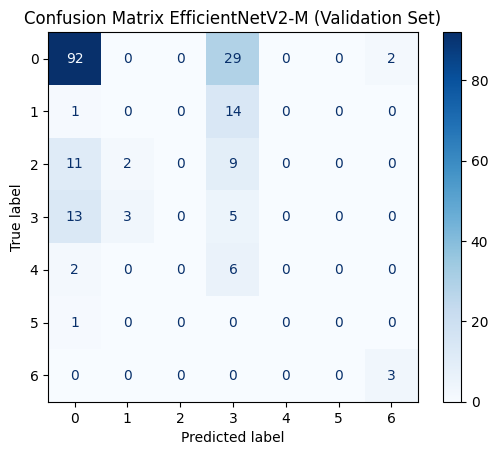

In [54]:
disp = conf_matrix(ds_validate_EN, modelENV2M)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix EfficientNetV2-M (Validation Set)')
plt.show()

### ResNet Models

In [26]:
ds_train_RN = ds_train.map(msp.resNetPrep)
ds_validate_RN = ds_validate.map(msp.resNetPrep)
ds_test_RN = ds_test.map(msp.resNetPrep)

#### ResNet50V2

In [27]:
modelRN50V2 = models.Sequential([
    base_modelRN50V2,
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(NUM_CLASSES, activation="softmax"),
])

modelRN50V2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
modelRN50V2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 2, 2, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,622,215 (93.93 MB)

 Trainable params: 24,576,775 (93.75 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [28]:
start_time = time.time()
histRN50V2 = modelRN50V2.fit(ds_train_RN, epochs=EPOCHS, validation_data=ds_validate_RN)
end_time = time.time()
duration = end_time - start_time
print(f"Model ResNet50V2 Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

Epoch 1/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 370s 5s/step - accuracy: 0.1552 - loss: 2.0780 - val_accuracy: 0.6373 - val_loss: 86.0836
Epoch 2/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 349s 4s/step - accuracy: 0.2712 - loss: 1.8377 - val_accuracy: 0.6373 - val_loss: 8.4722
Epoch 3/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 328s 4s/step - accuracy: 0.2408 - loss: 1.8063 - val_accuracy: 0.6373 - val_loss: 1.5367
Epoch 4/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 304s 4s/step - accuracy: 0.2997 - loss: 1.6953 - val_accuracy: 0.6373 - val_loss: 1.8948
Epoch 5/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 320s 4s/step - accuracy: 0.3187 - loss: 1.6736 - val_accuracy: 0.0777 - val_loss: 3.4784
Epoch 6/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 301s 4s/step - accuracy: 0.3319 - loss: 1.6483 - val_accuracy: 0.6373 - val_loss: 1.3847
Epoch 7/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 320s 4s/step - accuracy: 0.3508 - loss: 1.5977 - val_accuracy: 0.0155 - val_loss: 7.5220
Epoch 8/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 326s 4s/step - accuracy: 0.3511 - loss: 1.5834 - val_accuracy: 0.1140 - val_loss

In [29]:
loss, accuracy = modelRN50V2.evaluate(ds_validate_RN)
print(f"Overall accuracy on validation set: {accuracy * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 373ms/step - accuracy: 0.1135 - loss: 3.3380
Overall accuracy on validation set: 11.40%


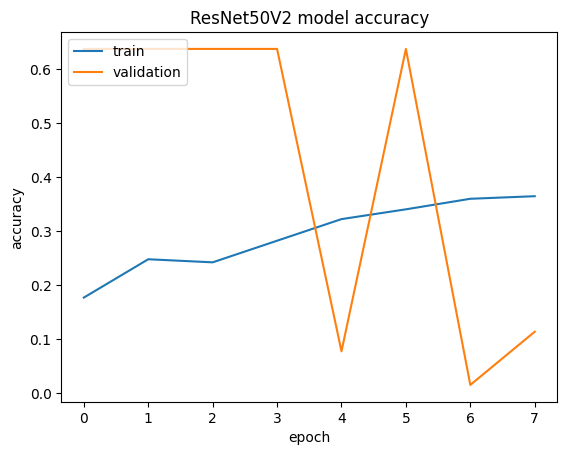

In [30]:
plot_hist(histRN50V2, "ResNet50V2")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


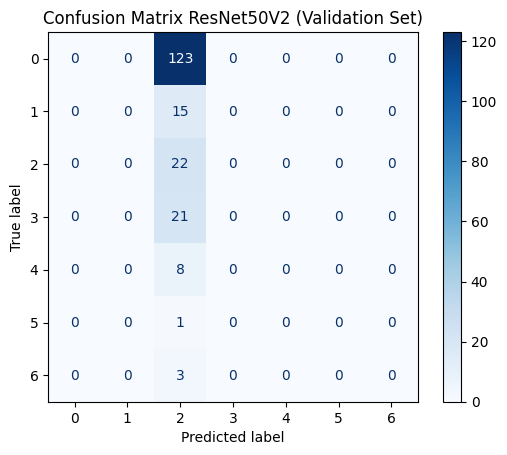

In [31]:
disp = conf_matrix(ds_validate_RN, modelRN50V2)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix ResNet50V2 (Validation Set)')
plt.show()

#### ResNet152V2

In [32]:
modelRN152V2 = models.Sequential([
    base_modelRN152V2,
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(NUM_CLASSES, activation="softmax"),
])

modelRN152V2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
modelRN152V2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152v2 (Functional)        │ (None, 2, 2, 2048)     │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,389,063 (226.55 MB)

 Trainable params: 59,245,319 (226.00 MB)

 Non-trainable params: 143,744 (561.50 KB)

In [33]:
start_time = time.time()
histRN152V2 = modelRN152V2.fit(ds_train_RN, epochs=EPOCHS, validation_data=ds_validate_RN)
end_time = time.time()
duration = end_time - start_time
print(f"Model ResNet152V2 Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

Epoch 1/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 738s 9s/step - accuracy: 0.1849 - loss: 2.0449 - val_accuracy: 0.6373 - val_loss: 136.9759
Epoch 2/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 571s 8s/step - accuracy: 0.3159 - loss: 1.7192 - val_accuracy: 0.6373 - val_loss: 1.5564
Epoch 3/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 629s 9s/step - accuracy: 0.2958 - loss: 1.7182 - val_accuracy: 0.0777 - val_loss: 1.8856
Epoch 4/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 621s 9s/step - accuracy: 0.3707 - loss: 1.6391 - val_accuracy: 0.1347 - val_loss: 1.9171
Epoch 5/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 621s 9s/step - accuracy: 0.3786 - loss: 1.6054 - val_accuracy: 0.0777 - val_loss: 2.1672
Epoch 6/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 637s 9s/step - accuracy: 0.4229 - loss: 1.4685 - val_accuracy: 0.0777 - val_loss: 2.4488
Epoch 7/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 619s 9s/step - accuracy: 0.4445 - loss: 1.4765 - val_accuracy: 0.0777 - val_loss: 1.7746
Epoch 8/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 607s 8s/step - accuracy: 0.4130 - loss: 1.4436 - val_accuracy: 0.1140 - val_los

In [34]:
loss, accuracy = modelRN152V2.evaluate(ds_validate_RN)
print(f"Overall accuracy on validation set: {accuracy * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.1135 - loss: 2.4711
Overall accuracy on validation set: 11.40%


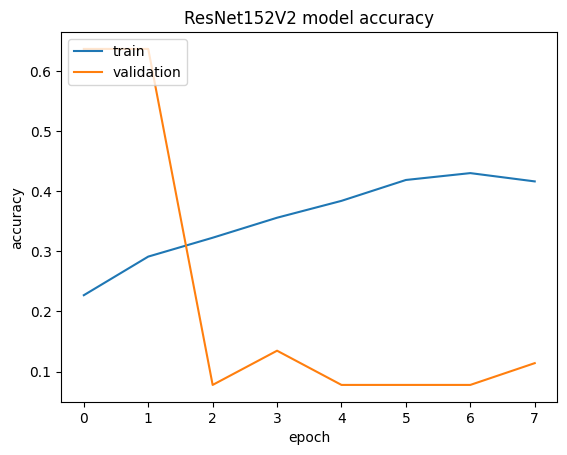

In [35]:
plot_hist(histRN152V2, "ResNet152V2")

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


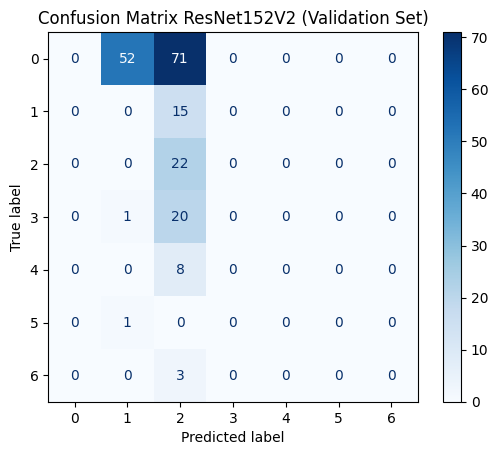

In [36]:
disp = conf_matrix(ds_validate_RN, modelRN152V2)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix ResNet152V2 (Validation Set)')
plt.show()

### Inception Models

#### InceptionV3

InceptionV3 requires images sizes of minimum 75x75, therefore this model was not applied to the dataset in this experiment.

### DenseNet Models

In [37]:
ds_train_DN = ds_train.map(msp.denseNetPrep)
ds_validate_DN = ds_validate.map(msp.denseNetPrep)
ds_test_DN = ds_test.map(msp.denseNetPrep)

#### DenseNet121

In [38]:
modelDN121 = models.Sequential([
    base_modelDN121,
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(NUM_CLASSES, activation="softmax"),
])

modelDN121.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
modelDN121.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 2, 2, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,570,631 (28.88 MB)

 Trainable params: 7,486,983 (28.56 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [39]:
start_time = time.time()
histDN121 = modelDN121.fit(ds_train_DN, epochs=EPOCHS, validation_data=ds_validate_DN)
end_time = time.time()
duration = end_time - start_time
print(f"Model DenseNet121 Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

Epoch 1/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.1993 - loss: 2.1174 - val_accuracy: 0.0155 - val_loss: 6.2518
Epoch 2/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.3186 - loss: 1.7274 - val_accuracy: 0.0052 - val_loss: 2.7599
Epoch 3/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.3115 - loss: 1.7146 - val_accuracy: 0.1140 - val_loss: 1.8366
Epoch 4/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.3347 - loss: 1.6598 - val_accuracy: 0.0777 - val_loss: 1.8444
Epoch 5/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.3634 - loss: 1.5683 - val_accuracy: 0.0777 - val_loss: 2.5949
Epoch 6/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.3965 - loss: 1.4971 - val_accuracy: 0.0155 - val_loss: 2.8575
Epoch 7/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.4163 - loss: 1.4653 - val_accuracy: 0.0777 - val_loss: 1.7001
Epoch 8/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.4671 - loss: 1.3416 - val_accuracy: 0.0155 - val_loss:

In [40]:
loss, accuracy = modelDN121.evaluate(ds_validate_DN)
print(f"Overall accuracy on validation set: {accuracy * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 582ms/step - accuracy: 0.0084 - loss: 3.8124
Overall accuracy on validation set: 1.55%


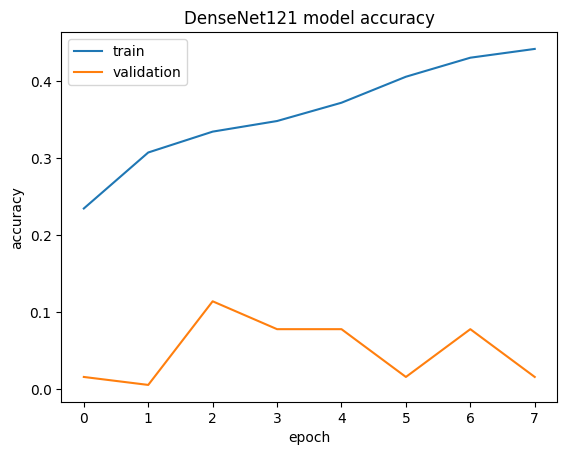

In [41]:
plot_hist(histDN121, "DenseNet121")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


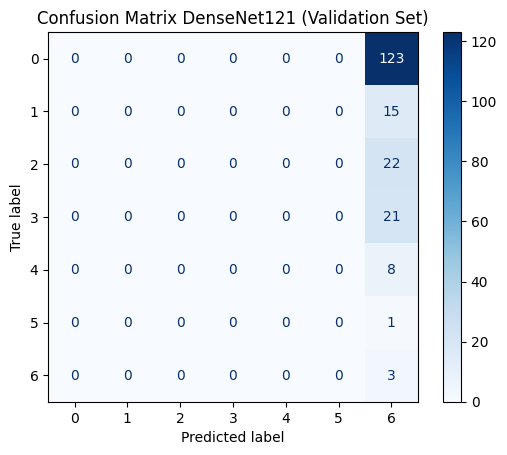

In [42]:
disp = conf_matrix(ds_validate_DN, modelDN121)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix DenseNet121 (Validation Set)')
plt.show()

#### DenseNet201

In [43]:
modelDN201 = models.Sequential([
    base_modelDN201,
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(NUM_CLASSES, activation="softmax"),
])

modelDN201.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

modelDN201.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 2, 2, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 7680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │       983,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,313,863 (73.68 MB)

 Trainable params: 19,084,807 (72.80 MB)

 Non-trainable params: 229,056 (894.75 KB)

In [44]:
start_time = time.time()
histDN201 = modelDN201.fit(ds_train_DN, epochs=EPOCHS, validation_data=ds_validate_DN)
end_time = time.time()
duration = end_time - start_time
print(f"Model DenseNet201 Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

Epoch 1/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 386s 3s/step - accuracy: 0.1628 - loss: 2.1684 - val_accuracy: 0.0777 - val_loss: 1.7423
Epoch 2/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 222s 3s/step - accuracy: 0.1944 - loss: 1.8879 - val_accuracy: 0.0155 - val_loss: 1.9974
Epoch 3/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 259s 3s/step - accuracy: 0.1784 - loss: 1.8946 - val_accuracy: 0.6373 - val_loss: 1.3749
Epoch 4/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.1718 - loss: 1.8862 - val_accuracy: 0.6373 - val_loss: 1.6852
Epoch 5/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.1557 - loss: 1.9468 - val_accuracy: 0.5078 - val_loss: 1.8834
Epoch 6/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.1388 - loss: 1.9462 - val_accuracy: 0.0829 - val_loss: 1.9750
Epoch 7/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 264s 3s/step - accuracy: 0.1594 - loss: 1.9463 - val_accuracy: 0.0155 - val_loss: 1.9814
Epoch 8/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 223s 3s/step - accuracy: 0.1432 - loss: 1.9466 - val_accuracy: 0.0777 - val_loss:

In [45]:
loss, accuracy = modelDN201.evaluate(ds_validate_DN)
print(f"Overall accuracy on validation set: {accuracy * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 501ms/step - accuracy: 0.1000 - loss: 1.9687
Overall accuracy on validation set: 7.77%


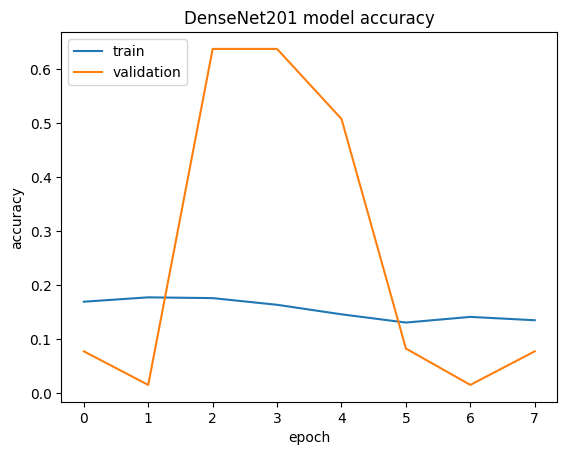

In [46]:
plot_hist(histDN201, "DenseNet201")

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


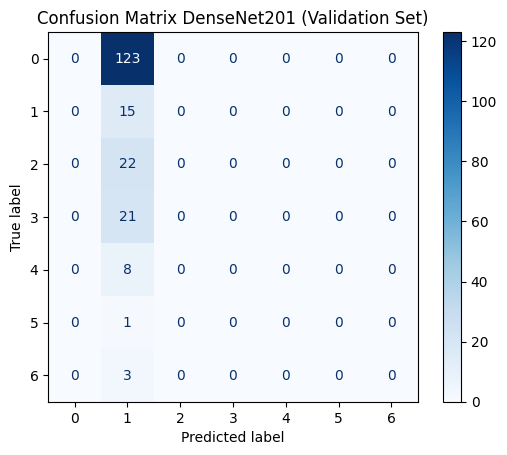

In [47]:
disp = conf_matrix(ds_validate_DN, modelDN201)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix DenseNet201 (Validation Set)')
plt.show()